<a href="https://colab.research.google.com/github/AlwaysEden/Temperature-Forecast/blob/main/RandomForest_Temperature_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install skforecast


In [2]:
from os.path import split
import requests
import json
from datetime import datetime, timedelta
import pandas as pd
from zoneinfo import ZoneInfo
from re import X
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.ndimage import gaussian_filter1d
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import RandomForestRegressor

In [37]:
#Required - loc: 지역 지점 번호 (관련 자료는 기상청 지상종관관측 지점 번호 참고)
def weatherLatestData(loc, startDt, endDt):  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))

  #startDt = three_hours_ago.strftime("%Y%m%d%H00")
  #endDt = now.strftime(f"%Y%m%d%H00")
  #startDt = '202412090800'
  #endDt = "202501080800"
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항)
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn={loc}&help=0&authKey=Qj-2vEE8RNq_trxBPJTacA'.format(startDt=startDt, endDt=endDt, loc=loc)

  # GET 요청
  response = requests.get(url)
  print(response.status_code)
  if response.status_code != 200:
    return None

  print(response)
  splited_response = response.text.splitlines()
  print(splited_response)
  if len(splited_response) <= 4:
    return None

  result_lines = splited_response[3:len(splited_response) - 1]


  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  # 예제 시계열 데이터 생성
  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  return df

#Required - loc: 지역 지점 번호 (관련 자료는 기상청 지상종관관측 지점 번호 참고)
def weatherPastData(loc):  #기상청API에서 온도 데이터를 받아 파싱
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  one_month_ago = now - timedelta(days=30)

  startDt = one_month_ago.strftime("%Y%m%d%H00")
  endDt = now.strftime(f"%Y%m%d%H00")
  startDt = '202412090800'
  endDt = "202501080800"
  print(startDt)
  print(endDt)

  # URL 문자열, stn=138(포항)
  url = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm5.php?tm1={startDt}&tm2={endDt}&obs=TA&stn={loc}&help=0&authKey=Qj-2vEE8RNq_trxBPJTacA'.format(startDt=startDt, endDt=endDt, loc=loc)

  # GET 요청
  response = requests.get(url)

  splited_response = response.text.splitlines()
  result_lines = splited_response[3:len(splited_response) - 1]

  temperature_list = []
  for line in result_lines:
    line = line.split(',')
    temperature_list.append(float(line[5]))

  # 예제 시계열 데이터 생성
  date_rng = pd.date_range(start=startDt, end=endDt, freq='h')
  df = pd.DataFrame({'ds': date_rng, 'y': temperature_list})

  return df

#Required- X: x좌표, Y: y좌표 (관련 자료는 기상청 단기예보 오픈 API 활용가이드 참고)
def weatherFutureData(X, Y): #x좌표, y좌표
  now = datetime.now(ZoneInfo('Asia/Seoul'))
  base_time = now.strftime("%H00")
  base_time = '0800'

  #base_time: 2시부터 3시간 간격으로 증가. (02, 05, 08, 11, 14...)
  if base_time == '0200' or base_time == '0500' or base_time == '0800' or base_time == '1100' or base_time == '1400' or base_time == '1700' or base_time == '2000' or base_time == '2300':
    base_date = now.strftime("%Y%m%d")

    # URL 문자열, numOfRows: 288(1일치, 12*24)
    url = f'https://apihub.kma.go.kr/api/typ02/openApi/VilageFcstInfoService_2.0/getVilageFcst?pageNo=1&numOfRows=288&dataType=JSON&base_date={base_date}&base_time={base_time}&nx={X}&ny={Y}&authKey=5aFO0TIuTfehTtEyLq33zA'

    response = requests.get(url)

    json_response = response.json()

    future_tmp = []
    fcstTime = json_response['response']['body']['items']['item'][0]['fcstTime']
    for x in json_response['response']['body']['items']['item']:
      if x['category'] == 'TMP':
        future_tmp.append(round(float(x['fcstValue']),2))

    startDt = now.strftime("%Y%m%d") + fcstTime
    print(startDt)
    #startDt = '202501071200'
    date_rng = pd.date_range(start=startDt, periods=24, freq='h')
    df = pd.DataFrame({'ds': date_rng, 'external_param': future_tmp})
    return df

  return 0

# Linear Regression을 활용한 현장온도 예측

In [63]:
#데이터 다운로드

weatherData = weatherPastData(138) #138 포항
factoryData = weatherPastData(184) #184 제주도

factoryData['y'] = factoryData['y'] + 5
factoryData['y'] = gaussian_filter1d(factoryData['y'], sigma=4) #제주도 데이터를 공장 현장데이터로 사용하려고하다보니 완만한 변화율이 필요했음.
#factoryData['external_param'] = weatherData['y']

steps = 24 # 예측하고자하는 시간
factory_trainingData = factoryData.iloc[:(len(factoryData)-steps)]
factory_testData = factoryData.iloc[(len(factoryData)-steps):]

202412090800
202501080800
202412090800
202501080800


In [64]:
X_train, X_valid, y_train, y_valid = train_test_split(weatherData[['y']], factoryData[['y']], test_size=0.2, random_state=0)

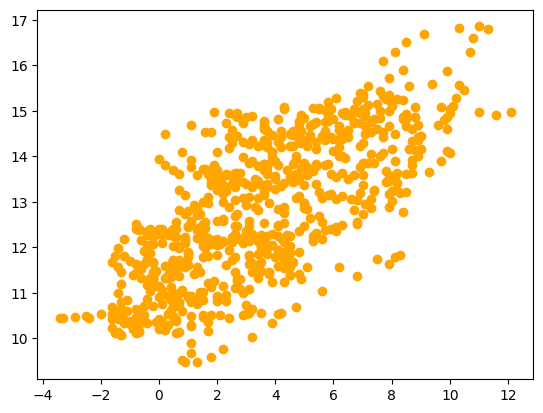

In [65]:
plt.scatter(weatherData['y'], factoryData['y'],color='orange')
plt.show()

In [66]:

params = {
    'n_estimators':(100, 200),
    'max_depth' : (5, 8),
    'min_samples_leaf' : (8, 18),
    'min_samples_split' : (8, 16)
}

regressor = RandomForestRegressor(random_state=123)
grid_cv = GridSearchCV(regressor, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


최적 예측 정확도: 0.4763


In [69]:
print(predictions)
print(X_valid)

697    10.670685
698    10.657553
699    10.646622
700    10.624277
701    10.570687
702    10.545192
703    10.528900
704    10.493056
705    10.414722
706    10.374203
707    10.351258
708    10.345319
709    10.296753
710    10.295590
711    10.283382
712    10.229613
713    10.185903
714    10.176335
715    10.283538
716    10.403200
717    10.567873
718    10.752890
719    10.926286
720    11.137202
Name: pred, dtype: float64
       y
503  1.8
646 -0.2
245  7.5
142  1.7
493  3.6
..   ...
382  0.6
97   2.9
415  8.7
540  3.5
475 -0.5

[145 rows x 1 columns]


0.882211812754272


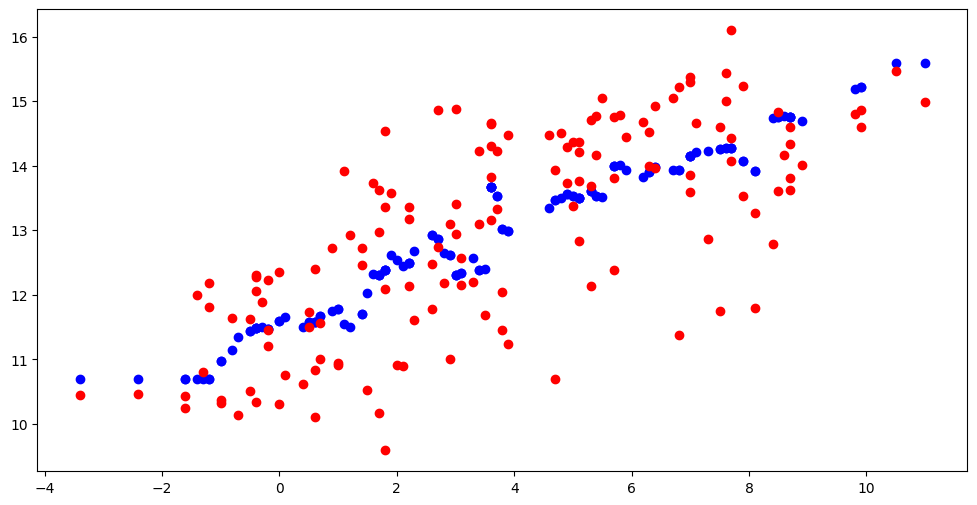

In [72]:
predictions = grid_cv.predict(X_valid)
mae = mean_absolute_error(y_valid, predictions)
print(mae)
plt.figure(figsize=(12, 6))
plt.scatter(X_valid, predictions,color='blue')
plt.scatter(X_valid, y_valid,color='red')
plt.show()

# Recursive multi-step forecaster를 활용한 시계열 데이터 예측




In [54]:
#데이터 다운로드
#weatherData = weatherPastData(138) #138 포항
factoryData = weatherPastData(184) #184 제주도

factoryData['y'] = factoryData['y'] + 5
factoryData['y'] = gaussian_filter1d(factoryData['y'], sigma=4) #제주도 데이터를 공장 현장데이터로 사용하려고하다보니 완만한 변화율이 필요했음.
#factoryData['external_param'] = weatherData['y']

steps = 24 # 예측하고자하는 시간
data_train = factoryData.iloc[:(len(factoryData)-steps)]
data_valid = data_train[-steps:]
data_test = factoryData.iloc[(len(factoryData)-steps):]
#factory_trainingData = factoryData.iloc[:(len(factoryData)-steps)]
#factory_testData = factoryData.iloc[(len(factoryData)-steps):]

202412090800
202501080800


In [59]:
regressor = RandomForestRegressor(random_state=123)
best_mae = float('inf')
best_lag = None
best_predictions = None
data_train = data_train['y']
data_valid = data_valid['y']
data_test = data_test['y']

for i in range(3, 24):
  forecaster = ForecasterRecursive(
                  regressor = regressor,
                  lags      = i             )
  forecaster.fit(y=data_train)
  predictions = forecaster.predict(
                    steps = steps
                )
  mae = mean_absolute_error(data_valid, predictions)
  if(mae < best_mae):
    best_mae = mae
    best_lag = i
    best_predictions = predictions

In [60]:
print(best_mae)

1.2354693559411987


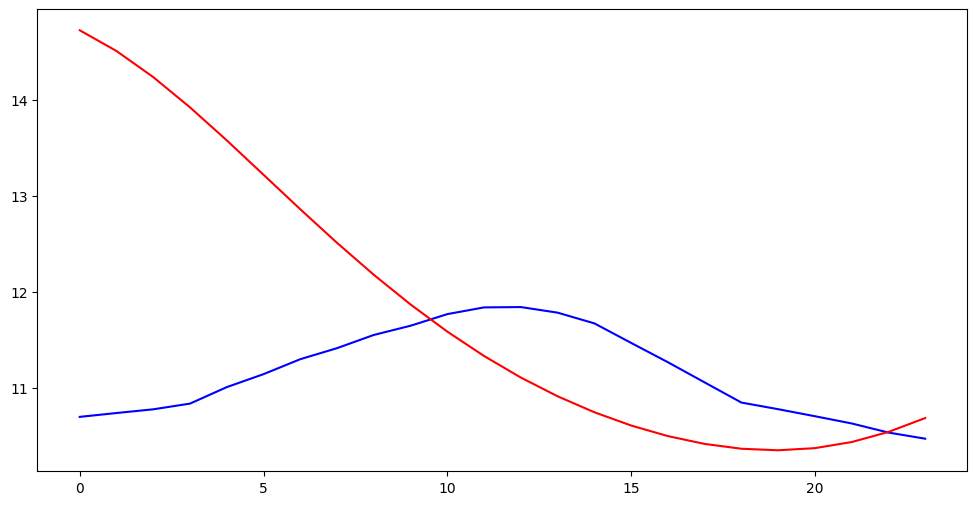

In [61]:
xline = [i for i in range(len(y_valid))]
plt.figure(figsize=(12, 6))
plt.plot(xline, best_predictions,color='blue')
plt.plot(xline, data_valid,color='red')
plt.show()

# Recursive multi-step forecaster에 외생변수를 추가하여 활용한 시계열 데이터 예측

In [73]:
#데이터 다운로드
weatherData = weatherPastData(138) #138 포항
factoryData = weatherPastData(184) #184 제주도

factoryData['y'] = factoryData['y'] + 5
factoryData['y'] = gaussian_filter1d(factoryData['y'], sigma=4) #제주도 데이터를 공장 현장데이터로 사용하려고하다보니 완만한 변화율이 필요했음.
factoryData['external_param'] = weatherData['y']

steps = 24 # 예측하고자하는 시간
factory_trainingData = factoryData.iloc[:(len(factoryData)-steps)]
factory_testData = factoryData.iloc[(len(factoryData)-steps):]

202412090800
202501080800
202412090800
202501080800


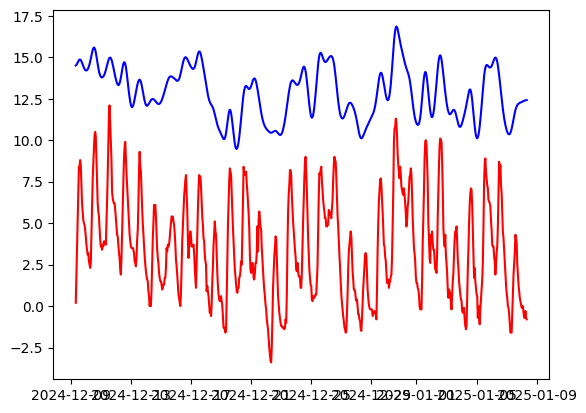

In [74]:

from matplotlib import pyplot as plt
plt.plot(weatherData['ds'], weatherData['y'],color='red')
plt.plot(weatherData['ds'], factoryData['y'],color='blue')
plt.show()

In [75]:

regressor = RandomForestRegressor(random_state=123)
best_mae = float('inf')
best_lag = None
best_predictions = None

for i in range(3, 24):
  forecaster = ForecasterRecursive(
                  regressor = regressor,
                  lags      = i             )
  forecaster.fit(y=factory_trainingData['y'], exog=factory_trainingData['external_param'])
  predictions = forecaster.predict(
                    steps = steps,
                    exog = factory_testData['external_param']
                )
  mae = mean_absolute_error(factory_testData['y'], predictions)
  if(mae < best_mae):
    best_mae = mae
    best_lag = i
    best_predictions = predictions


0.5320561967060167


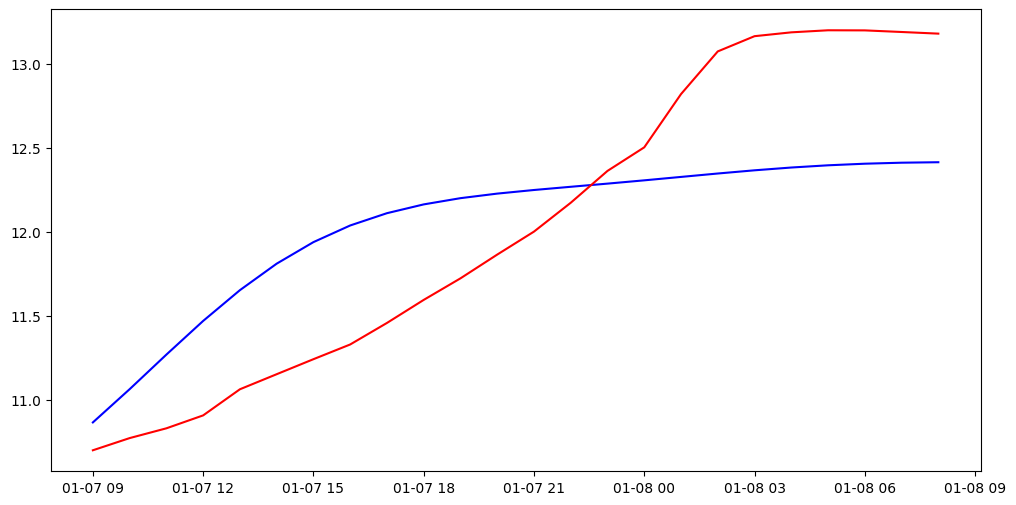

In [76]:
print(best_mae)
plt.figure(figsize=(12, 6))
plt.plot(factory_testData['ds'], factory_testData['y'],color='blue')
plt.plot(factory_testData['ds'], best_predictions,color='red')
plt.show()
